In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

In [ ]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [ ]:
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

training_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testing_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

image_w = 32
image_h = 32

100%|██████████| 170498071/170498071 [00:05<00:00, 28588770.76it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),                         #Random cropping
    transforms.RandomHorizontalFlip(),                            #Random flipping
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)),  #Random Rotation and translation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load CIFAR-10 data
training_dataset_augment = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testing_dataset_augment = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


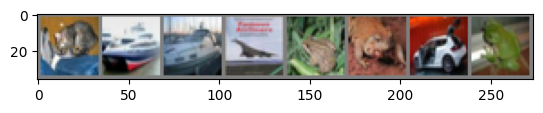

Labels:   cat,  ship,  ship, plane,  frog,  frog,   car,  frog


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

num_images = 8

# get some random training images
trainloader = torch.utils.data.DataLoader(testing_dataset, batch_size=num_images)
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:",', '.join('%5s' % classes[labels[j]] for j in range(num_images)))

In [ ]:
import math
curr_best_test_loss = math.inf

In [ ]:
use_cuda = torch.cuda.is_available()
print("Using GPU?:",use_cuda)
if (use_cuda):
  print("GPU Name:",torch.cuda.get_device_name())
  device = torch.device("cuda")
else:
  device = torch.device("cpu")


Using GPU?: True
GPU Name: Tesla T4


In [ ]:
def train(network,  data_generator, loss_function, optimize, logging = 200):
  network.train() #updates any network layers that behave differently in training and execution 
  avg_loss = 0
  num_batches = 0
  for batch, (input_data, target_output) in enumerate(data_generator):
    input_data, target_output = input_data.to(device), target_output.to(device) #Move tensor to GPU
    optimizer.zero_grad()                            # Gradients need to be reset each batch
    prediction = network(input_data)                 # Forward pass: compute the output class given a image
    loss = loss_function(prediction, target_output)  # Compute the loss: difference between the output and correct result
    loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
    if ((batch+1)%logging == 0): print('Batch [%d/%d], Train Loss: %.4f' %(batch+1, len(data_generator.dataset)/len(target_output), avg_loss/num_batches))
  return avg_loss/num_batches

def test(network, test_loader, loss_function):
  network.eval() #updates any network layers that behave differently in training and execution 
  test_loss = 0
  num_batches = 0
  with torch.no_grad(): 
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = network(data)
      test_loss += loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      num_batches += 1
  test_loss /= num_batches
  #print('\nTest set: Avg. loss: {:.4f})\n'.format(test_loss))
  return test_loss

def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)


def graphConfusionMatrix(test_datset, num_samples=10000):
  data_generator = torch.utils.data.DataLoader(test_datset, batch_size=num_samples)
  data_enumerator = enumerate(data_generator)
  _, (images,labels) = next(data_enumerator)
  with torch.no_grad():
      pred_catigories = network(images) #all 10 values
      pred_labels = pred_catigories.data.max(1, keepdim=True)[1] #only the highest value is the final prediction
  conf_mat = confusion_matrix(labels.numpy(), pred_labels.numpy(), normalize = "pred")
  plt.figure(figsize=(8,5))
  sns.heatmap(conf_mat, annot=True, fmt="0.2f", xticklabels = classes, yticklabels = classes,
              cmap = "gnuplot") #colormaps: gnuplot hot RdPu inferno viridis BuPu RdBu_r coolwarm
  plt.xlabel("Target Class")
  plt.ylabel("Predicted Class")

def trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, early_stopping=True, logging_interval=1, ):
  #Arrays to store training history
  test_loss_history = []
  epoch_counter = []
  train_loss_history = []
  last_loss = 999999
  best_loss = 999999
  for epoch in range(num_epochs):                           
    avg_loss = train(network, training_generator, loss_function, optimizer)
    test_loss = test(network, testing_generator, loss_function)
    logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)
    if (test_loss < 0.43): 
      break
    if (test_loss <best_loss):
      best_loss = test_loss
      torch.save(network.state_dict(), 'best_model.pt')
    last_loss = test_loss
    old_params = network.parameters()
      
  graphLoss(epoch_counter, train_loss_history, test_loss_history)

In [ ]:
def computeLabelAccuracy(networkModel, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  networkModel.eval()
  with torch.no_grad():
    for data, target in data_loader:
      data, target = data.to(device), target.to(device)
      output = networkModel(data)
      pred = output.data.max(1, keepdim=True)[1]  #Check if the maximum/largest output class matches the label
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))
  
  
def drawPredictionsCIFAR10(networkModel, dataset, num_rows=6, num_cols = 10, skip_batches=0):
  #Plot some of the testing results 
  networkModel.eval()
  data_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=num_rows*num_cols)
  data_enumerator = enumerate(data_generator)
  for i in range(skip_batches):  
     _, (images,labels) = next(data_enumerator) #skip a few batches if needed
  _, (images,labels) = next(data_enumerator)
  images, labels = images.to(device), labels.to(device)
  with torch.no_grad():
    pred_catigories = networkModel(images) #all 10 values
    pred_labels = pred_catigories.data.max(1, keepdim=True)[1] #only the highest value is the final prediction
  for row in range(num_rows):
    fig = plt.figure(figsize=(num_cols+6,5)) #adjust the plot size
    for i in range(num_cols):
      plt.subplot(1,num_cols,i+1)
      cur = i + row*num_cols
      #plt.tight_layout()
      drawColor = 'black'
      if pred_labels[cur].item() != labels[cur]:
        drawColor = 'red'
      img = images[cur] / 2 + 0.5     # unnormalize
      npimg = img.cpu().numpy()
      plt.imshow(np.transpose(npimg, (1, 2, 0)))  #, interpolation='none'
      plt.title(" O: {},\n L: {}".format(classes[pred_labels[cur].item()],classes[labels[cur]]), color=drawColor)
      plt.xticks([])
      plt.yticks([])

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
class GaussianNoise(nn.Module):
  def __init__(self, sigma=0.1):
    super().__init__()
    self.sigma = sigma
    self.register_buffer('noise', torch.tensor(0))

  def forward(self, x):
    if self.training and self.sigma != 0: #If we are evaluating the network (not training) do nothing!
        scale = self.sigma * x.detach() #Detach so there is no gradient on sigma
        sampled_noise = self.noise.expand(*x.size()).float().normal_() * scale
        x = x + sampled_noise
    return x 

In [ ]:
class CNN_Best2(nn.Module):
    def __init__(self, img_w, img_h, num_classes): #lets assume 32x32 image, hidden_channels = 8
        super().__init__()  
        kernel_size = 3
        num_kernels = 128
        self.conv1 = nn.Conv2d(3, 32, kernel_size=kernel_size)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=kernel_size)
        #.conv4 = nn.Conv2d(50, 50, kernel_size=kernel_size)

        new_w2 = (img_w-(kernel_size-1))
        new_h2 = (img_h-(kernel_size-1))

        new_w3 = (new_w2-(kernel_size-1))//2
        new_h3 = (new_h2-(kernel_size-1))//2
        
        new_w4 = (new_w3-(kernel_size-1))//2
        new_h4 = (new_h3-(kernel_size-1))//2

        self.flattened_dim = (new_w4*new_h4) * num_kernels 

        self.linear1 = nn.Linear(self.flattened_dim, 1000)
        self.linear2 = nn.Linear(1000, 100)
        self.linear3 = nn.Linear(100, num_classes)
        #self.noise = GaussianNoise(0.05)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(50)
        #Implement the above archetucure
    
    def forward(self, x):       # Forward pass which defines how the layers relate the input x to the output out
        #Implement the above archetucure
        #print("flattened dim ", self.flattened_dim)
        #x = self.noise(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = (F.max_pool2d(x,kernel_size=2))
        x = F.relu(self.bn3(self.conv3(x)))
        x = (F.max_pool2d(x,kernel_size=2))
        x = x.view(-1, self.flattened_dim)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

Num. Parameters: 4803906
Data is Loaded
Epoch [1/40], Train Loss: 1.6089, Test Loss: 1.3115
Epoch [2/40], Train Loss: 1.2135, Test Loss: 0.9802
Epoch [3/40], Train Loss: 1.0527, Test Loss: 0.9483
Epoch [4/40], Train Loss: 0.9589, Test Loss: 0.8438
Epoch [5/40], Train Loss: 0.8887, Test Loss: 0.7510
Epoch [6/40], Train Loss: 0.8367, Test Loss: 0.7411
Epoch [7/40], Train Loss: 0.7893, Test Loss: 0.6942
Epoch [8/40], Train Loss: 0.7631, Test Loss: 0.6603
Epoch [9/40], Train Loss: 0.7237, Test Loss: 0.6667
Epoch [10/40], Train Loss: 0.7116, Test Loss: 0.6306
Epoch [11/40], Train Loss: 0.6813, Test Loss: 0.6217
Epoch [12/40], Train Loss: 0.6605, Test Loss: 0.6770
Epoch [13/40], Train Loss: 0.6351, Test Loss: 0.5894
Epoch [14/40], Train Loss: 0.6266, Test Loss: 0.6093
Epoch [15/40], Train Loss: 0.6042, Test Loss: 0.5863
Epoch [16/40], Train Loss: 0.5947, Test Loss: 0.5529
Epoch [17/40], Train Loss: 0.5800, Test Loss: 0.5561
Epoch [18/40], Train Loss: 0.5676, Test Loss: 0.5482
Epoch [19/40], 

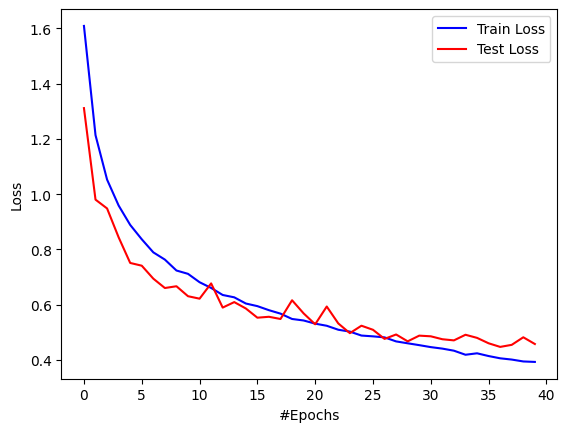

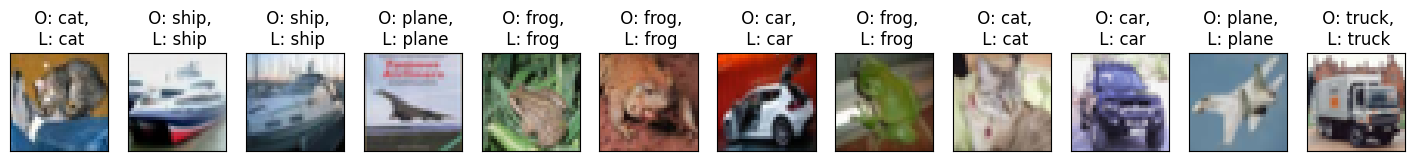

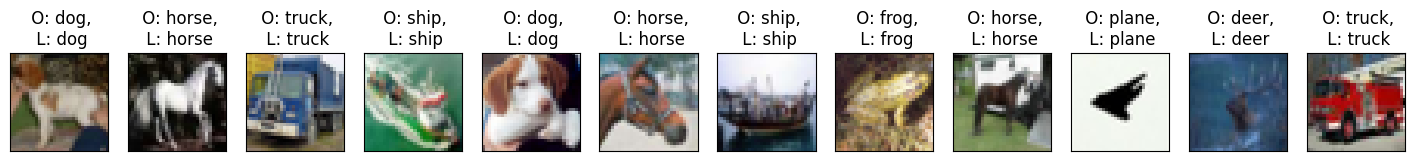

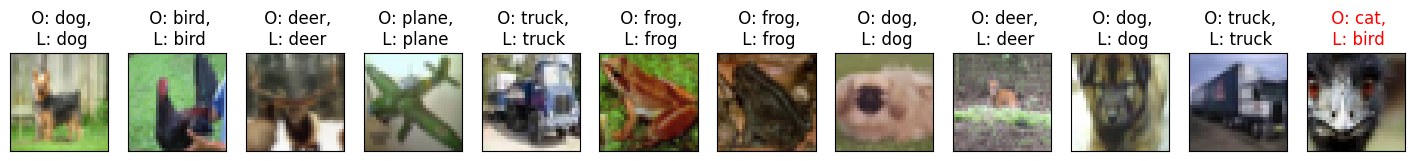

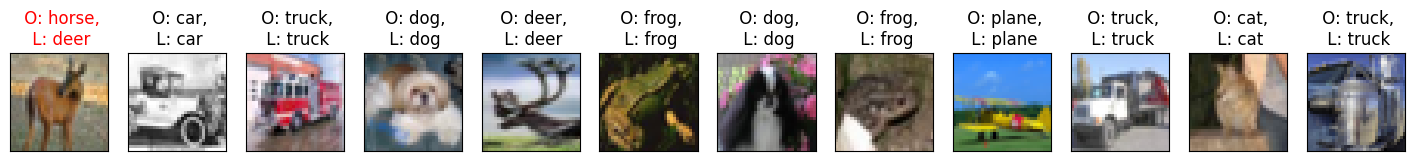

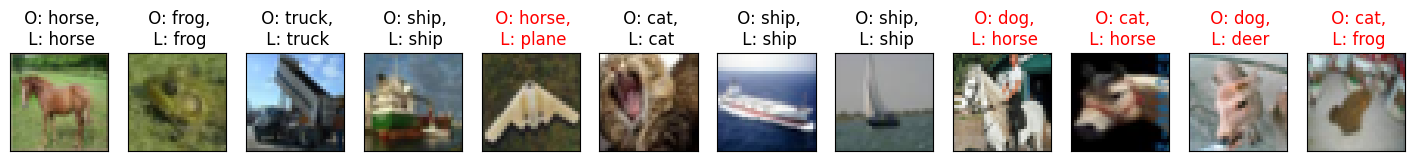

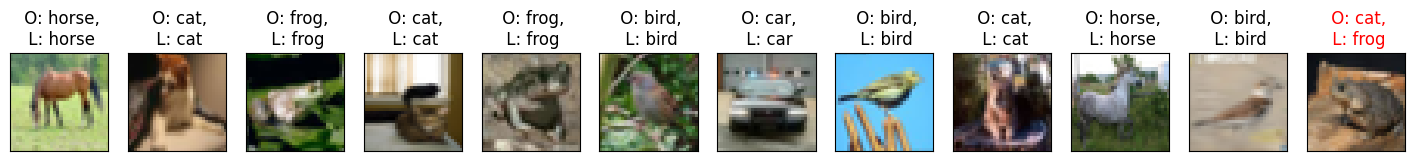

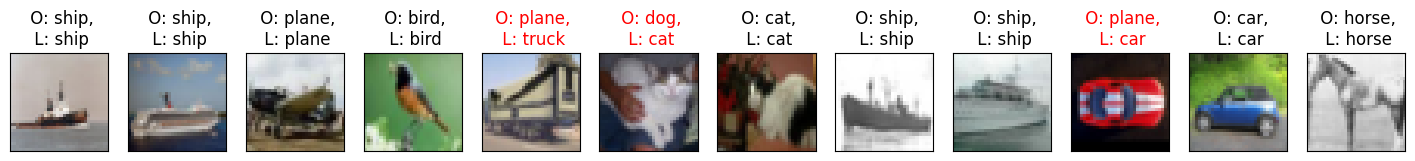

In [ ]:
#Training parameters
num_epochs = 40
print_interval = 1
learning_rate = 0.001
batch_size = 300
num_kernels = 10
kernel_size = 5

#Create model
network = CNN_Best2(image_w, image_h, 10)
network = network.to(device)

print("Num. Parameters:", count_parameters(network))

#Set optimizer and loss function
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset_augment, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset_augment, batch_size=batch_size, shuffle=False)

print("Data is Loaded")

trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

computeLabelAccuracy(network, training_generator, "Train Set")
computeLabelAccuracy(network, testing_generator, "Test Set")
drawPredictionsCIFAR10(network, testing_dataset, 7, 12, 0)


Train Set: Accuracy: 43360/50000 (86.7%)

Test Set: Accuracy: 8499/10000 (85.0%)


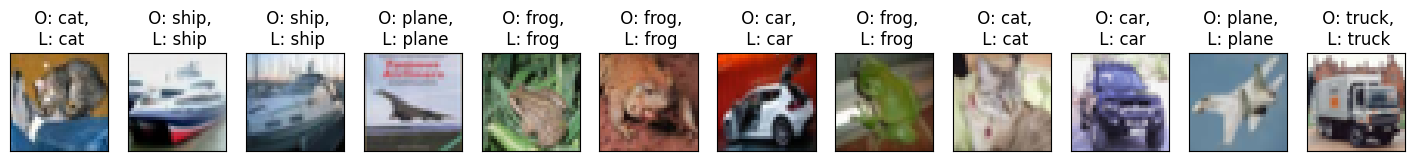

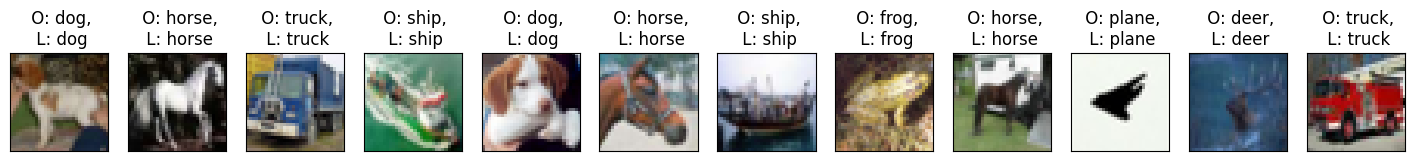

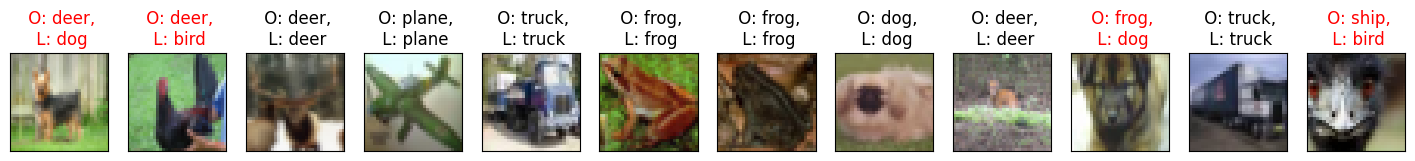

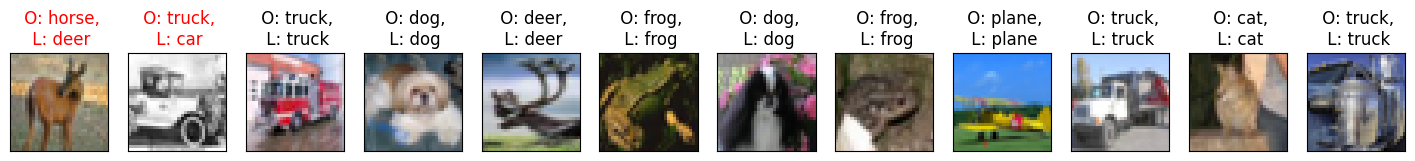

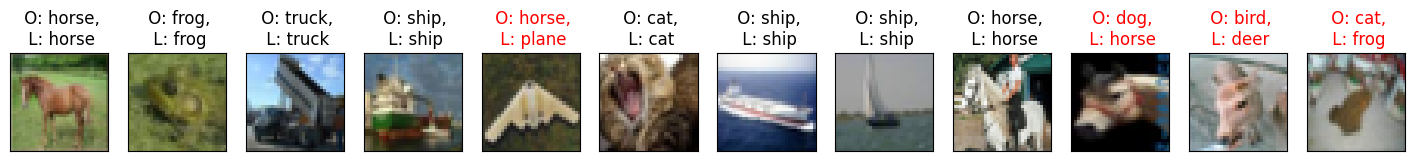

In [ ]:
#Load the best saved network
#network = CNN_Best2(image_w, image_h, num_kernels, kernel_size, 10)
network = CNN_Best2(image_w, image_h, 10)
network = network.to(device)
network.load_state_dict(torch.load("best_model.pt"))
network.eval()

#Run it to compute the stats & results
computeLabelAccuracy(network, training_generator, "Train Set")
computeLabelAccuracy(network, testing_generator, "Test Set")
drawPredictionsCIFAR10(network, testing_dataset, 5, 12, 0)

In [ ]:
class CNN_Best(nn.Module):
    def __init__(self, img_w, img_h, num_classes): #lets assume 32x32 image, hidden_channels = 8
        super().__init__()  
        kernel_size = 3
        num_kernels = 64
        self.conv1 = nn.Conv2d(3, 32, kernel_size=kernel_size)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size)

        new_w = (img_w-(kernel_size-1))
        new_h = (img_h-(kernel_size-1))

        new_w2 = (new_w-(kernel_size-1))//2
        new_h2 = (new_h-(kernel_size-1))//2
        
        self.flattened_dim = (new_w2*new_h2) * num_kernels 

        self.linear1 = nn.Linear(self.flattened_dim, 1000)
        self.linear2 = nn.Linear(1000, num_classes)
        #Implement the above archetucure
    
    def forward(self, x):       # Forward pass which defines how the layers relate the input x to the output out
        #Implement the above archetucure
        #print("flattened dim ", self.flattened_dim)
        x = self.conv1(x)
        #print(x.shape)
        x = F.relu(x)
        x = self.conv2(x)
        #print(x.shape)

        x = F.max_pool2d(x,kernel_size=2)
        #print(x.shape)
        x = F.relu(x)
        #print(x.shape)
        x = x.view(-1, self.flattened_dim)
        #print(x.shape)
        x = self.linear1(x)
        #print(x.shape)
        x = self.linear2(x)
       # print(x.shape)
        return x


# **OLD**

In [ ]:
class Convolution_1Layer_mpks(nn.Module):
    def __init__(self, img_w, img_h, num_kernels, num_classes, kernel_size): #lets assume 28x28 image, hidden_channels = 16
        super().__init__()  
        self.conv1 = nn.Conv2d(3, num_kernels, kernel_size=kernel_size)       #28x28 -> 26x26 x 16
        new_w = (img_w-(kernel_size-1))//2 # without padding a kernel will shrink
        new_h = (img_h-(kernel_size-1))//2 #  the image by (kernel_size-1)
        self.flattened_dim = (new_w*new_h) * num_kernels          #13x13 * 16 -> 2704
        self.linear1 = nn.Linear(self.flattened_dim, num_classes)   #2704 -> 10
    
    def forward(self, x):       # Forward pass which defines how the layers relate the input x to the output out
        x = self.conv1(x)
        x = F.hardtanh(F.max_pool2d(x,kernel_size=2))
        x = x.view(-1, self.flattened_dim)
        x = self.linear1(x)
        return x

Loaded Data
Epoch [1/5], Train Loss: 1.6621, Test Loss: 1.5159
Epoch [2/5], Train Loss: 1.4673, Test Loss: 1.4439
Epoch [3/5], Train Loss: 1.3836, Test Loss: 1.3905
Epoch [4/5], Train Loss: 1.3320, Test Loss: 1.3343
Epoch [5/5], Train Loss: 1.2891, Test Loss: 1.3421

Test Set: Accuracy: 28236/50000 (56.5%)

Train Set: Accuracy: 5338/10000 (53.4%)


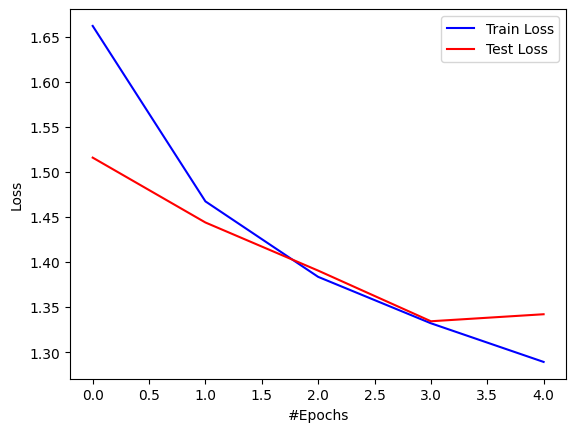

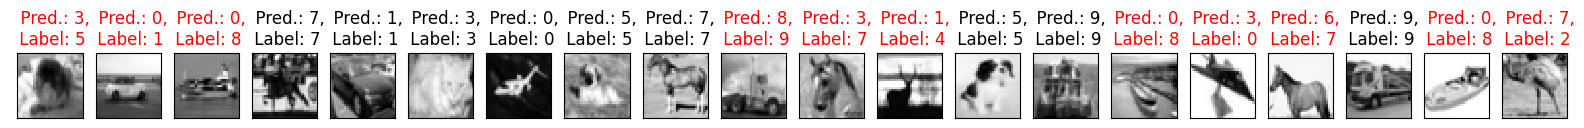

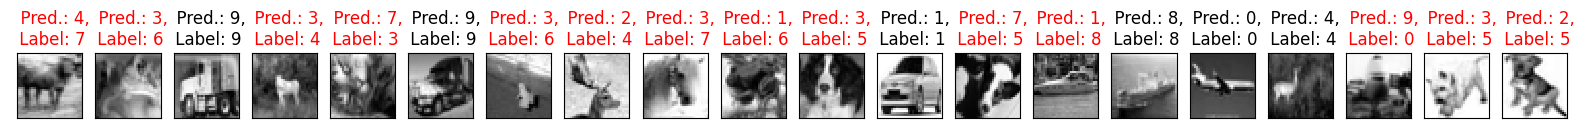

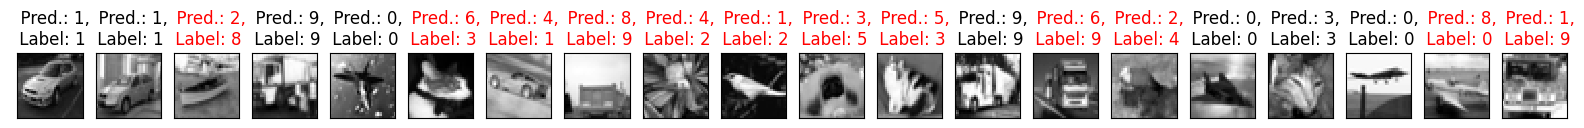

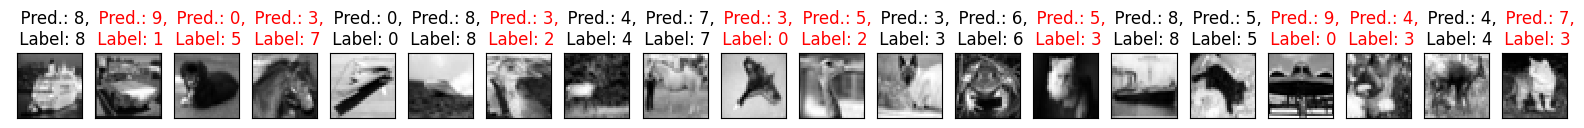

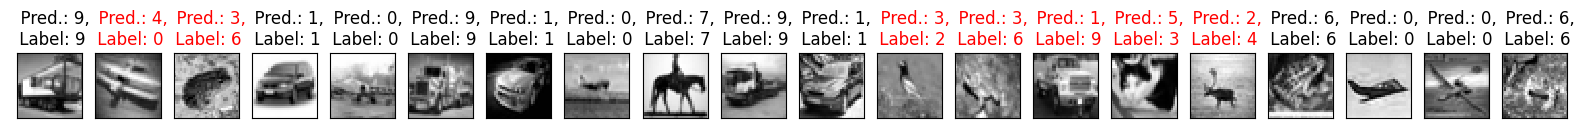

In [ ]:
#Training parameters
num_epochs = 5
print_interval = 1
learning_rate = 0.001
batch_size = 25
num_kernels = 8

#Create model
predModel = Convolution_1Layer_mpks(image_w, image_h, num_kernels, 10, 3)

#Set optimizer and loss function
network = predModel;
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)

print("Loaded Data")

trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

computeLabelAccuracy(network, training_generator, "Test Set")
computeLabelAccuracy(network, testing_generator, "Train Set")
drawPredictionsMNIST(network, testing_dataset, 5, 20, 2)

In [ ]:
class Convolution_1Layer_mpks(nn.Module):
    def __init__(self, img_w, img_h, num_kernels, num_classes, kernel_size): #lets assume 28x28 image, hidden_channels = 16
        super().__init__()  
        self.conv1 = nn.Conv2d(3, num_kernels, kernel_size=kernel_size)       #28x28 -> 26x26 x 16
        new_w = (img_w-(kernel_size-1))//2 # without padding a kernel will shrink
        new_h = (img_h-(kernel_size-1))//2 #  the image by (kernel_size-1)
        self.flattened_dim = (new_w*new_h) * num_kernels          #13x13 * 16 -> 2704
        self.linear1 = nn.Linear(self.flattened_dim, num_classes)   #2704 -> 10
    
    def forward(self, x):       # Forward pass which defines how the layers relate the input x to the output out
        x = self.conv1(x)
        x = F.leaky_relu(F.max_pool2d(x,kernel_size=2))
        x = x.view(-1, self.flattened_dim)
        x = self.linear1(x)
        return x

Loaded Data
Epoch [1/5], Train Loss: 1.6137, Test Loss: 1.4312
Epoch [2/5], Train Loss: 1.3706, Test Loss: 1.3645
Epoch [3/5], Train Loss: 1.3042, Test Loss: 1.3088
Epoch [4/5], Train Loss: 1.2695, Test Loss: 1.2957
Epoch [5/5], Train Loss: 1.2420, Test Loss: 1.2790

Test Set: Accuracy: 29285/50000 (58.6%)

Train Set: Accuracy: 5474/10000 (54.7%)


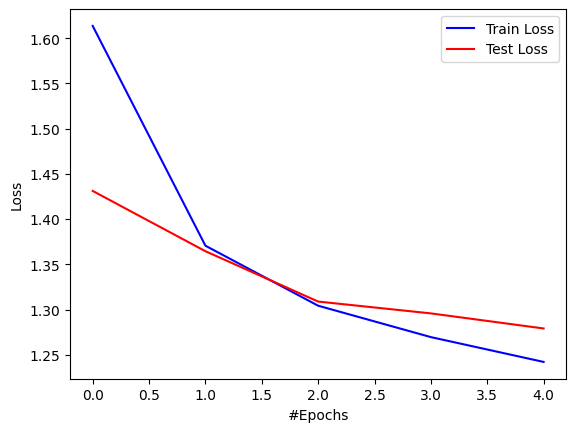

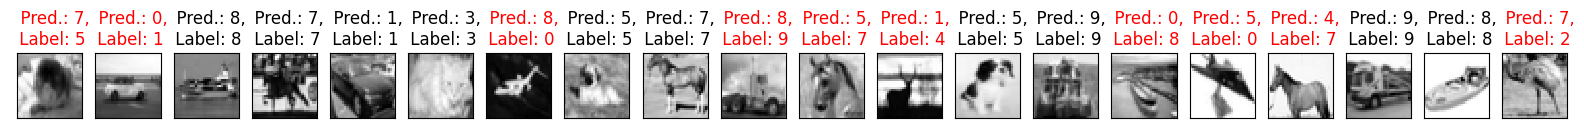

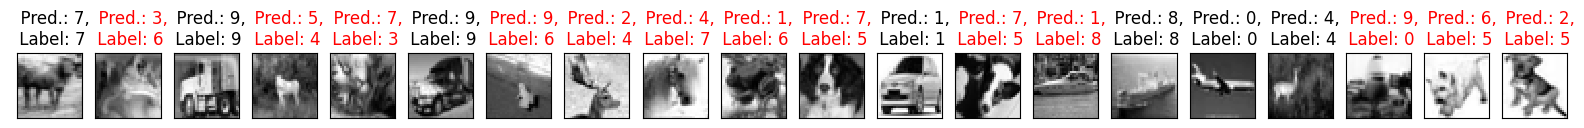

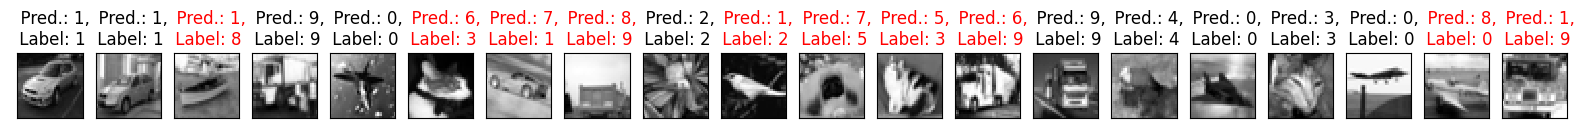

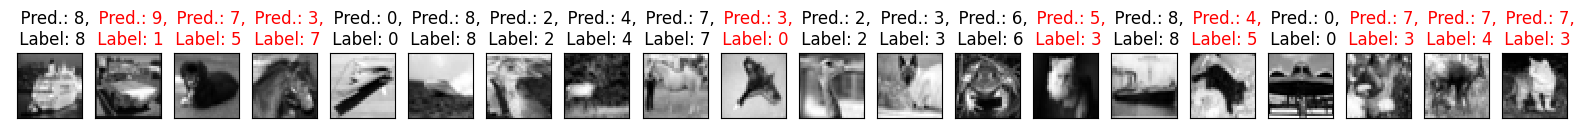

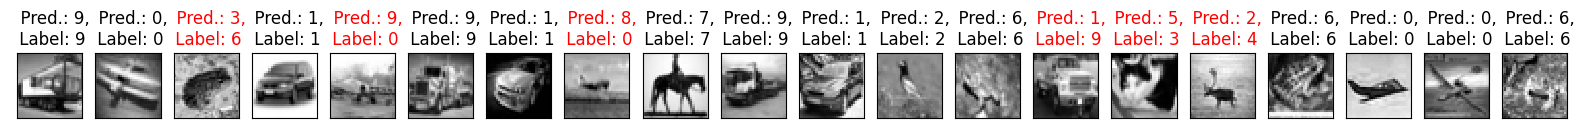

In [ ]:
#Training parameters
num_epochs = 5
print_interval = 1
learning_rate = 0.001
batch_size = 25
num_kernels = 8

#Create model
predModel = Convolution_1Layer_mpks(image_w, image_h, num_kernels, 10, 3)

#Set optimizer and loss function
network = predModel;
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)

print("Loaded Data")

trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

computeLabelAccuracy(network, training_generator, "Test Set")
computeLabelAccuracy(network, testing_generator, "Train Set")
drawPredictionsMNIST(network, testing_dataset, 5, 20, 2)

In [ ]:
def stuff(epochs, lr, batch, kernels, kernelsize, predModel):
  #Training parameters
  num_epochs = epochs
  print_interval = 5
  learning_rate = lr
  batch_size = batch
  num_kernels = kernels

  #Create model

  #Set optimizer and loss function
  network = predModel;
  optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
  loss_function = nn.CrossEntropyLoss()

  #Load the data, and split it into batches
  training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
  testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)

  trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)
  print("Epochs: ", epochs, " LR: ", lr, " Batch size: ", batch, " Num_Kernels: ", kernels, "Kernel size: ", kernelsize)
  trainacc = computeLabelAccuracy(network, training_generator, "Train Set")

  testacc = computeLabelAccuracy(network, testing_generator, "Test Set")

  #drawPredictionsMNIST(network, testing_dataset, 5, 20, 2)
  return (testacc, [epochs, lr, batch, kernels, kernelsize])

In [ ]:
class Convolution_1Layer_mpks_relu(nn.Module):
    def __init__(self, img_w, img_h, num_kernels, num_classes, kernel_size): #lets assume 28x28 image, hidden_channels = 16
        super().__init__()  
        self.conv1 = nn.Conv2d(3, num_kernels, kernel_size=kernel_size)       #28x28 -> 26x26 x 16
        new_w = (img_w-(kernel_size-1))//2 # without padding a kernel will shrink
        new_h = (img_h-(kernel_size-1))//2 #  the image by (kernel_size-1)
        self.flattened_dim = (new_w*new_h) * num_kernels          #13x13 * 16 -> 2704
        self.linear1 = nn.Linear(self.flattened_dim, 1000)
        self.linear2 = nn.Linear(1000, 50)
        self.linear3 = nn.Linear(50, num_classes)   #2704 -> 10  #2704 -> 10
    
    def forward(self, x):       # Forward pass which defines how the layers relate the input x to the output out
        x = self.conv1(x)
        x = F.relu(F.max_pool2d(x,kernel_size=2))
        x = x.view(-1, self.flattened_dim)
        x = self.linear1(x)
        return x

Epoch [1/15], Train Loss: 1.6185, Test Loss: 1.3977
Epoch [6/15], Train Loss: 1.1956, Test Loss: 1.2437
Epoch [11/15], Train Loss: 1.1080, Test Loss: 1.2020
Epochs:  15  LR:  0.001  Batch size:  25  Num_Kernels:  10 Kernel size:  3

Train Set: Accuracy: 32083/50000 (64.2%)

Test Set: Accuracy: 5842/10000 (58.4%)


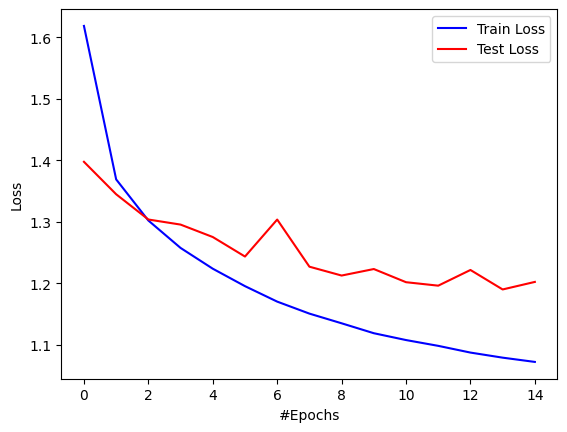

In [ ]:
predModel = Convolution_1Layer_mpks_relu(image_w, image_h, 10, 10, 3)
output = stuff(15, 0.001, 25, 10, 3, predModel)

Loaded Data
Epoch [1/5], Train Loss: 1.6514, Test Loss: 1.5519
Epoch [2/5], Train Loss: 1.4949, Test Loss: 1.4598
Epoch [3/5], Train Loss: 1.4061, Test Loss: 1.4360
Epoch [4/5], Train Loss: 1.3323, Test Loss: 1.3325
Epoch [5/5], Train Loss: 1.2826, Test Loss: 1.3152

Test Set: Accuracy: 28937/50000 (57.9%)

Train Set: Accuracy: 5404/10000 (54.0%)


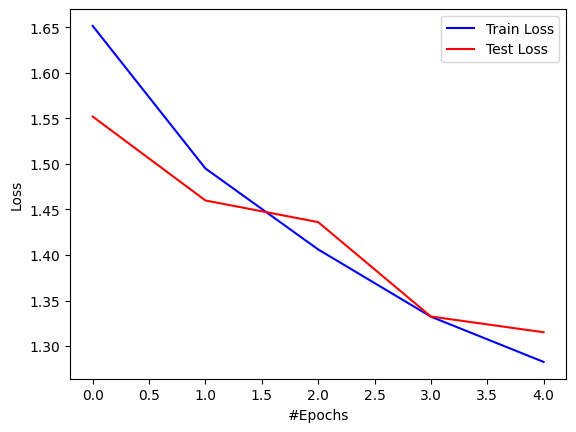

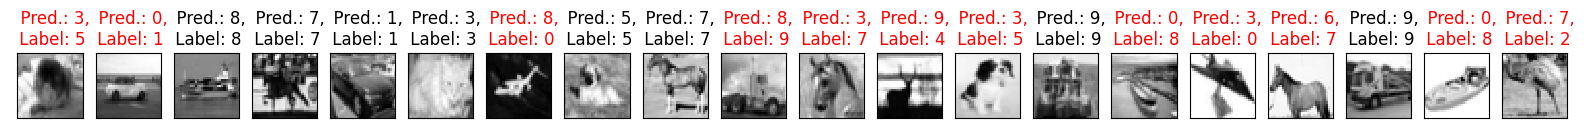

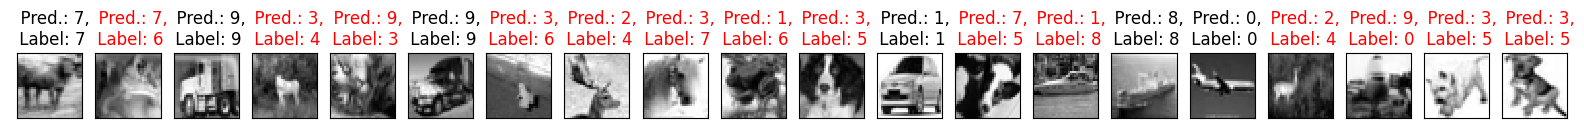

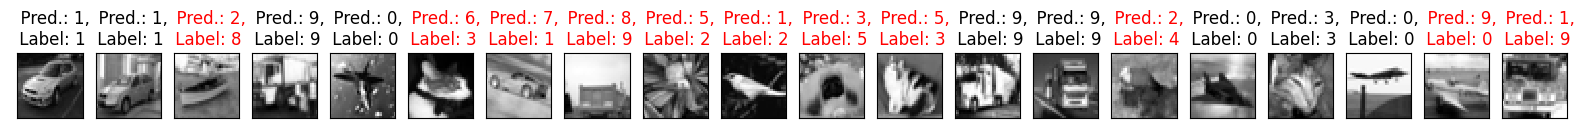

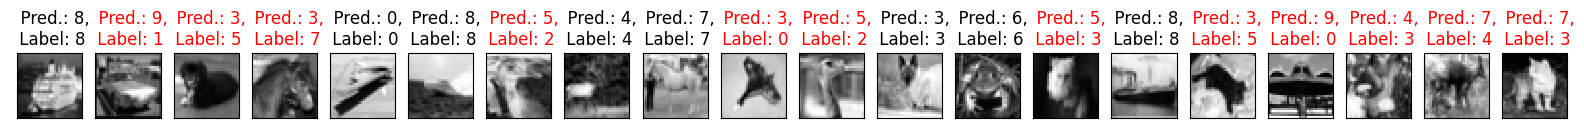

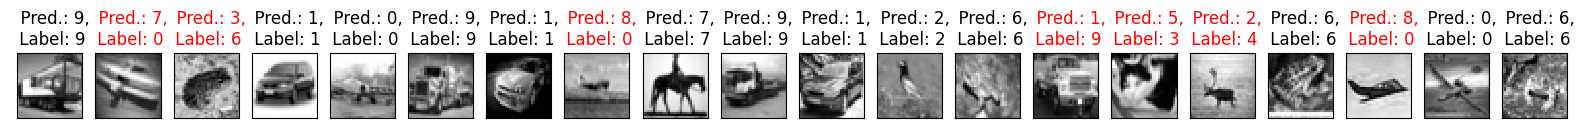

In [ ]:
#Training parameters
num_epochs = 5
print_interval = 1
learning_rate = 0.001
batch_size = 100
num_kernels = 8

#Create model
predModel = Convolution_1Layer_mpks(image_w, image_h, num_kernels, 10, 3)

#Set optimizer and loss function
network = predModel;
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=True)

print("Loaded Data")

trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

computeLabelAccuracy(network, training_generator, "Test Set")
computeLabelAccuracy(network, testing_generator, "Train Set")
drawPredictionsMNIST(network, testing_dataset, 5, 20, 2)

#**Part 1: CIFAR-10 Prediction**


Explain	carefully	your	final	model	and	training	approach.	
This	should	include	the	number	of	epochs,	batch	size,	your	loss	function,	which	layers	are	
in	your	network,	the	size	of	each	layer,	activation	function,	and	so	on.	For	full	credit,	you	
must	show	an	image	illustrating	the	network	architecture.

# **Part 2: Model Saving & Loading**

Report	both	the	model	
accuracy	and	a	classification	confusion	matrix.

# **Part 3: Classification Accuracy**

What	is	your	test	classification	accuracy	on	the	CIFAR	
testing	data	after	loading	your	saved	model?